In [1]:
import keras
import random
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam, Nadam
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.random.seed(42) # NumPy
random.seed(42) # Python
tf.random.set_seed(42) # Tensorflow

In [3]:
# importing train and test data
train_data = pd.read_pickle('train_knn_scaled.pkl')
test_data = pd.read_pickle('test_knn_scaled.pkl')

In [4]:
train_data.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C9,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V3,V4,V6,V8,V11,V13,V18,V20,V30,V36,V37,V40,V44,V47,V48,V52,V54,V60,V70,V76,V78,V80,V81,V82,V87,V91,V99,V127,V130,V131,V139,V147,V156,V165,V166,V169,V171,V173,V174,V175,V176,V180,V183,V185,V195,V198,V203,V205,V207,V209,V210,V215,V216,V220,V221,V223,V230,V234,V235,V238,V240,V241,V250,V252,V257,V258,V260,V262,V263,V264,V265,V268,V271,V274,V277,V282,V283,V289,V291,V303,V307,V310,V312,V315,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_33,id_35,id_36,id_37,DeviceType,DeviceInfo,TransactionHR,TransactionMT,TransactionDW,dollars,cents,P_parent_domain,P_domain_name,P_top_level_domain,card1_div_1000,card2_div_10,R_parent_domain,R_domain_name,R_top_level_domain,device_name,device_version,os_name,os_version,isFraud
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,-1.577987,-0.278167,4,3417,500,42,1,38,1,166,65,-0.137532,31,31,-0.098020,-0.092260,-0.059438,-0.21606,-0.112869,-0.046146,-0.208712,-0.087363,-0.047034,-0.243806,-0.147247,-0.509782,-0.503333,-0.189393,-0.764989,-0.460267,-1.195934,-0.103737,-4.513538,-0.563826,-1.045689,-1.416108,-1.833103,-0.195921,-0.766342,1,1,1,2,0,1,2,2,2,0.010592,-0.175584,0.254143,-0.138091,-0.107737,-1.399366,0.890708,-0.540222,0.461255,-0.664176,0.061639,-0.193368,-0.50417,-0.168338,-0.142639,-0.809739,-0.366593,0.851647,-0.51961,-0.664404,0.913909,-0.234737,-0.521953,-0.508172,-1.749900,-0.208365,-0.694394,-0.328713,-0.051788,-0.291683,-0.193128,-0.925854,-0.085075,-1.348424,0.712571,2.676527,-0.910925,-0.280643,-1.102703,-1.135389,-0.963413,-0.639484,-0.074947,-0.080622,-0.121898,1.288134,1.113841,-0.069666,-0.417482,-0.155259,-0.470968,-0.910392,-0.063384,-0.051487,-0.865095,-0.430636,-1.072947,-0.465980,-0.091838,-0.097009,-0.110508,-0.009912,-0.004928,0.202858,-0.045803,-0.093392,-0.074128,0.045677,-0.02215,-0.131410,-0.093252,-0.105377,-0.261197,-0.936267,-0.047519,-0.043218,0.198889,0.006181,-0.394673,-0.040598,-0.454041,-0.066412,-0.334849,-0.227587,-0.230241,0.540805,-0.925067,5.187305,0.029746,-0.555474,0.369252,3.588854,0.106113,0.115225,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,-1.822224,-1.714835,5,-0.278668,-0.447183,16,24,7,4,51,16,24,8,13,293,7,68,0
2987001,-1.577986,-0.443327,4,7922,303,42,2,2,1,173,65,-0.102667,16,31,-0.098020,-0.092260,-0.059438,-0.21606,-0.112869,-0.046146,-0.268682,-0.097964,-0.047034,-0.243806,-0.147247,-0.598665,-0.503333,-0.210014,-0.764989,-0.460267,-1.195934,-0.103737,-4.513538,-0.638507,-1.093292,-1.416108,-1.833103,-0.195921,-0.766342,2,2,2,0,1,1,2,2,2,0.010592,-0.175584,0.254143,-0.138091,-0.107737,-1.399366,-0.977175,-0.540222,0.461255,-0.664176,-0.925159,-0.193368,-0.50417,-0.168338,-0.142639,-0.809739,-0.366593,-0.999398,-0.51961,-0.664404,-0.959375,-0.234737,-0.521953,-0.508172,0.498307,-0.208365,-0.694394,-0.328713,-0.079398,-0.291683,-0.193128,-0.925854,-0.085075,-1.348424,0.712571,2.676527,-0.910925,-0.280643,-1.102703,-1.135389,-0.963413,-0.639484,-0.074947,-0.080622,-0.121898,1.288134,1.113841,-0.069666,-0.417482,-0.155259,-0.470968,-0.910392,-0.063384,-0.051487,-0.865095,-0.430636,-1.072947,-0.465980,-0.091838,-0.097009,-0.110508,-0.009912,-0.004928,0.202858,-0.045803,-0.093392,-0.074128,0.045677,-0.02215,-0.131410,-0.093252,-0.105377,-0.261197,-0.936267,-0.047519,-0.043218,0.198889,0.006181,-0.394673,-0.040598,-0.454041,-0.093051,-0.334849,-0.227587,-0.230241,0.540805,-0.925067,5.187305,0.029746,-0.555474,0.369252,3.588854,0.106113,0.115225,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,-1.822224,-1.714835,5,-0.441734,-0.475884,12,15,2,10,30,16,24,8,13,293,7,68,0
2987002,-1.577972,-0.317889,4,938

In [5]:
# reset index of the train and test data
train_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)

# dropping datetime columns
drop_cols = ['TransactionDT', 'TransactionHR', 'TransactionMT', 'TransactionDW']
train_data.drop(drop_cols, axis=1, inplace=True)
test_data.drop(drop_cols, axis=1, inplace=True)

# saving the data
train_data.to_pickle('final_train_data.pkl')
test_data.to_pickle('final_test_data.pkl')

In [6]:
train_data.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C9,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V3,V4,V6,V8,V11,V13,V18,V20,V30,V36,V37,V40,V44,V47,V48,V52,V54,V60,V70,V76,V78,V80,V81,V82,V87,V91,V99,V127,V130,V131,V139,V147,V156,V165,V166,V169,V171,V173,V174,V175,V176,V180,V183,V185,V195,V198,V203,V205,V207,V209,V210,V215,V216,V220,V221,V223,V230,V234,V235,V238,V240,V241,V250,V252,V257,V258,V260,V262,V263,V264,V265,V268,V271,V274,V277,V282,V283,V289,V291,V303,V307,V310,V312,V315,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_33,id_35,id_36,id_37,DeviceType,DeviceInfo,dollars,cents,P_parent_domain,P_domain_name,P_top_level_domain,card1_div_1000,card2_div_10,R_parent_domain,R_domain_name,R_top_level_domain,device_name,device_version,os_name,os_version,isFraud
0,-0.278167,4,3417,500,42,1,38,1,166,65,-0.137532,31,31,-0.098020,-0.092260,-0.059438,-0.21606,-0.112869,-0.046146,-0.208712,-0.087363,-0.047034,-0.243806,-0.147247,-0.509782,-0.503333,-0.189393,-0.764989,-0.460267,-1.195934,-0.103737,-4.513538,-0.563826,-1.045689,-1.416108,-1.833103,-0.195921,-0.766342,1,1,1,2,0,1,2,2,2,0.010592,-0.175584,0.254143,-0.138091,-0.107737,-1.399366,0.890708,-0.540222,0.461255,-0.664176,0.061639,-0.193368,-0.50417,-0.168338,-0.142639,-0.809739,-0.366593,0.851647,-0.51961,-0.664404,0.913909,-0.234737,-0.521953,-0.508172,-1.749900,-0.208365,-0.694394,-0.328713,-0.051788,-0.291683,-0.193128,-0.925854,-0.085075,-1.348424,0.712571,2.676527,-0.910925,-0.280643,-1.102703,-1.135389,-0.963413,-0.639484,-0.074947,-0.080622,-0.121898,1.288134,1.113841,-0.069666,-0.417482,-0.155259,-0.470968,-0.910392,-0.063384,-0.051487,-0.865095,-0.430636,-1.072947,-0.465980,-0.091838,-0.097009,-0.110508,-0.009912,-0.004928,0.202858,-0.045803,-0.093392,-0.074128,0.045677,-0.02215,-0.131410,-0.093252,-0.105377,-0.261197,-0.936267,-0.047519,-0.043218,0.198889,0.006181,-0.394673,-0.040598,-0.454041,-0.066412,-0.334849,-0.227587,-0.230241,0.540805,-0.925067,5.187305,0.029746,-0.555474,0.369252,3.588854,0.106113,0.115225,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,-0.278668,-0.447183,16,24,7,4,51,16,24,8,13,293,7,68,0
1,-0.443327,4,7922,303,42,2,2,1,173,65,-0.102667,16,31,-0.098020,-0.092260,-0.059438,-0.21606,-0.112869,-0.046146,-0.268682,-0.097964,-0.047034,-0.243806,-0.147247,-0.598665,-0.503333,-0.210014,-0.764989,-0.460267,-1.195934,-0.103737,-4.513538,-0.638507,-1.093292,-1.416108,-1.833103,-0.195921,-0.766342,2,2,2,0,1,1,2,2,2,0.010592,-0.175584,0.254143,-0.138091,-0.107737,-1.399366,-0.977175,-0.540222,0.461255,-0.664176,-0.925159,-0.193368,-0.50417,-0.168338,-0.142639,-0.809739,-0.366593,-0.999398,-0.51961,-0.664404,-0.959375,-0.234737,-0.521953,-0.508172,0.498307,-0.208365,-0.694394,-0.328713,-0.079398,-0.291683,-0.193128,-0.925854,-0.085075,-1.348424,0.712571,2.676527,-0.910925,-0.280643,-1.102703,-1.135389,-0.963413,-0.639484,-0.074947,-0.080622,-0.121898,1.288134,1.113841,-0.069666,-0.417482,-0.155259,-0.470968,-0.910392,-0.063384,-0.051487,-0.865095,-0.430636,-1.072947,-0.465980,-0.091838,-0.097009,-0.110508,-0.009912,-0.004928,0.202858,-0.045803,-0.093392,-0.074128,0.045677,-0.02215,-0.131410,-0.093252,-0.105377,-0.261197,-0.936267,-0.047519,-0.043218,0.198889,0.006181,-0.394673,-0.040598,-0.454041,-0.093051,-0.334849,-0.227587,-0.230241,0.540805,-0.925067,5.187305,0.029746,-0.555474,0.369252,3.588854,0.106113,0.115225,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,-0.441734,-0.475884,12,15,2,10,30,16,24,8,13,293,7,68,0
2,-0.317889,4,9383,389,42,4,58,2,178,65,0.961748,36,31,-0.098020,-0.092260,-0.059438,-0.21606,-0.112869,-0.046146,-0.208712,-0.097964,-0.047034,-0.243806,-0.147247,-0.598665,-0.503333,-0.240946,-0.764989,-0.460267,-1.195934,-0.103737,-4.513538,-0.638507,1.165982,-1.416108,-1.833103,-0.195921,0.864292,1,1,1,0,0,0,0,0,0,0.010592,-0.175584,0.254143,-0.1380

In [7]:
# Feature selection
X = train_data.drop(['isFraud'], axis=1)
y = train_data['isFraud']

In [8]:
# split the data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)


In [9]:
# undersampling the data using random undersampler

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0, sampling_strategy=0.9)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [45]:
# X_val_resampled, y_val_resampled = rus.fit_resample(X_val, y_val)

In [10]:
y_val.value_counts(normalize=True)

isFraud
0    0.965675
1    0.034325
Name: proportion, dtype: float64

In [11]:
y_train_resampled.value_counts(normalize=True)

isFraud
0    0.52631
1    0.47369
Name: proportion, dtype: float64

In [12]:
y_train_resampled.shape

(35063,)

In [13]:
K.clear_session()

In [14]:
(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [38]:
# create a checkpoint callback to save model based on validation recall values
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_callback = ModelCheckpoint(
    filepath="./baseline_model/base_model_v1_epoch_{epoch:02d}_recall{val_recall:.2f}_auc{val_auc:.2f}_checkpoint.h5",
    monitor="val_recall",
    mode="max",
    save_best_only=True,
    verbose=1
)

# create earlystopping callback based on val_recall
early_stopping_callback = EarlyStopping(monitor="val_recall", mode="max", patience=10)


# create reduce lr on plateau callback
reduce_lr = ReduceLROnPlateau(monitor="val_recall", mode="max", patience=5, verbose=1, factor=0.1)
# create a callback list
callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr]


In [16]:
# create model function

def create_baseline_model(optimizer):
    # Create a baseline ANN model using keras for predicting binary classes of fraud
    # define ANN model
    model = keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=[X_train_resampled.shape[1]]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # add recall and auc as metrics
    recall = tf.keras.metrics.Recall(name='recall')
    auc = tf.keras.metrics.AUC(name='auc')

    # compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[recall, auc])

    return model


In [36]:
# choose adam as optimizer
from keras.optimizers import Adam
adam = Adam(learning_rate=0.003)
model = create_baseline_model(adam)

In [ ]:
history = model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=256, validation_data=(X_val, y_val), verbose=1, callbacks=callbacks)

In [23]:
import seaborn as sns

<Axes: xlabel='epoch', ylabel='recall'>

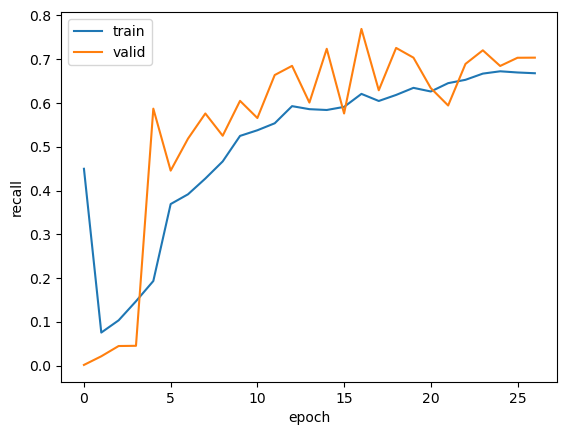

In [40]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch

sns.lineplot(data = history_df, x='epoch', y='recall', label='train')
sns.lineplot(data = history_df, x='epoch', y='val_recall', label='valid')

<Axes: xlabel='epoch', ylabel='auc'>

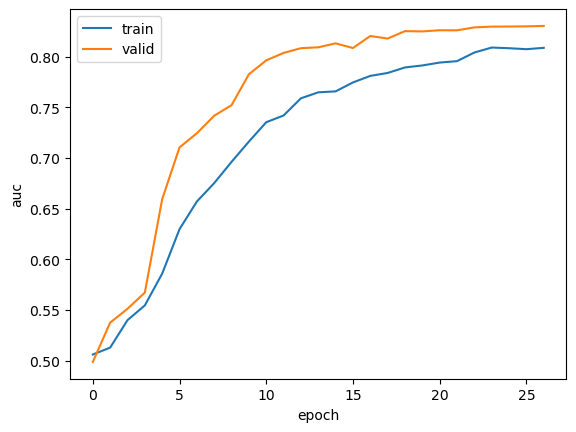

In [41]:
sns.lineplot(data = history_df, x='epoch', y='auc', label='train')
sns.lineplot(data = history_df, x='epoch', y='val_auc', label='valid')

In [42]:
def create_model_2(optimizer):
    
    model = keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(.3),
    # tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

    recall = tf.keras.metrics.Recall(name='recall')
    auc = tf.keras.metrics.AUC(name='auc')
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy', 
        metrics=[recall, auc]
        )
    return model

In [46]:
from keras.callbacks import ModelCheckpoint
checkpoint_callback2 = ModelCheckpoint(
    filepath="./model_v2/model_v2_epoch_{epoch:02d}_recall{val_recall:.2f}_auc{val_auc:.2f}_checkpoint.h5",
    monitor="val_recall",
    mode="max",
    save_best_only=True,    
    verbose=1
)

# create earlystopping callback based on val_recall
early_stopping_callback2 = EarlyStopping(monitor="val_recall", mode="max", patience=10)


# create reduce lr on plateau callback
reduce_lr2 = ReduceLROnPlateau(monitor="val_recall", mode="max", patience=5, verbose=1, factor=0.1)
# create a callback list
callbacks2 = [checkpoint_callback2, early_stopping_callback2, reduce_lr2]


In [47]:
adam_2 = Adam(learning_rate=0.03)
model2 = create_model_2(adam_2)

history_model2 = model2.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=256, validation_data=(X_val, y_val), verbose=1, callbacks=callbacks2)

Epoch 1/50
137/137 [==============================] - ETA: 0s - loss: 0.6605 - recall: 0.5365 - auc: 0.6702
Epoch 1: val_recall improved from -inf to 0.05846, saving model to ./model_v2/model_v2_epoch_01_recall0.06_auc0.63_checkpoint.h5
137/137 [==============================] - 68s 493ms/step - loss: 0.6605 - recall: 0.5365 - auc: 0.6702 - val_loss: 0.1663 - val_recall: 0.0585 - val_auc: 0.6273 - lr: 0.0300
Epoch 2/50
137/137 [==============================] - ETA: 0s - loss: 0.5476 - recall: 0.6353 - auc: 0.7915
Epoch 2: val_recall improved from 0.05846 to 0.23730, saving model to ./model_v2/model_v2_epoch_02_recall0.24_auc0.81_checkpoint.h5
137/137 [==============================] - 5s 34ms/step - loss: 0.5476 - recall: 0.6353 - auc: 0.7915 - val_loss: 0.1998 - val_recall: 0.2373 - val_auc: 0.8150 - lr: 0.0300
Epoch 3/50
135/137 [============================>.] - ETA: 0s - loss: 0.5300 - recall: 0.6551 - auc: 0.8063
Epoch 3: val_recall improved from 0.23730 to 0.90799, saving model 

<Axes: xlabel='epoch', ylabel='recall'>

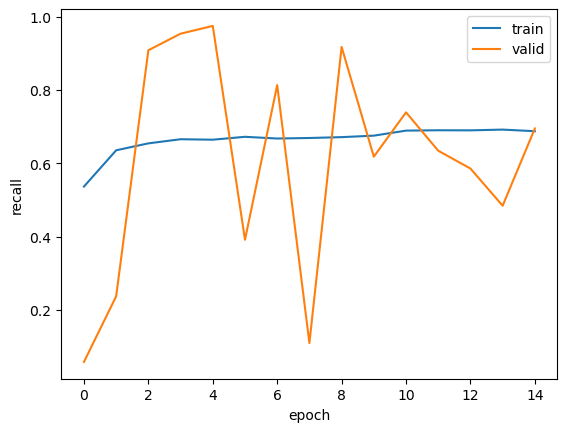

In [48]:
history2_df = pd.DataFrame(history_model2.history)
history2_df['epoch'] = history_model2.epoch

sns.lineplot(data = history2_df, x='epoch', y='recall', label='train')
sns.lineplot(data = history2_df, x='epoch', y='val_recall', label='valid')

## Model 1

In [49]:
# tensorflow model prediction

# model 1
y_pred = model.predict(X_val)
y_pred


3691/3691 [==============================] - 5s 1ms/step


array([[0.29079643],
       [0.44859818],
       [0.30966753],
       ...,
       [0.4572874 ],
       [0.44027764],
       [0.2601088 ]], dtype=float32)

In [50]:
y_pred_binary = np.round(y_pred).flatten()

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred_binary)

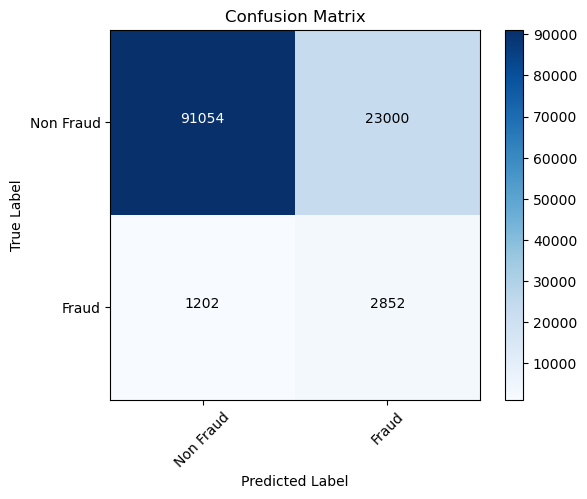

In [56]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(cm, ['Non Fraud', 'Fraud'])


In [57]:
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
fpr

0.20165886334543287

## Model 2

3691/3691 [==============================] - 6s 2ms/step


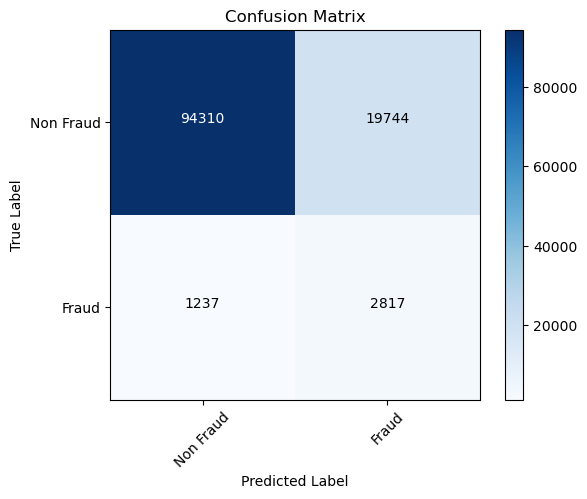

In [58]:
y_pred2 = model2.predict(X_val)
y_pred2_binary = np.round(y_pred2).flatten()

cm2 = confusion_matrix(y_val, y_pred2_binary)
plot_confusion_matrix(cm2, ['Non Fraud', 'Fraud'])

In [59]:
tn, fp, fn, tp = cm2.ravel()
fpr = fp / (fp + tn)
fpr

0.1731109825170533